<a href="https://colab.research.google.com/github/user1896/Neural-Network-image-classification/blob/main/ResNet/ResNet_train_and_save_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet Model

In [1]:
from __future__ import print_function
import json
import keras
import pickle
import os.path
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import AveragePooling2D, Input
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.regularizers import l2
from keras import optimizers
from keras import regularizers
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input
from keras.layers import add
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

# Load DataSet

In [2]:
# load train and test dataset
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = cifar10.load_data()
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

# Prepare Pixel Data

In [3]:
#We know that the pixel values for each image in the dataset are unsigned integers in the range
#between black and white, or 0 and 255. We do not know the best way to scale the pixel values
#for modeling, but we know that some scaling will be required. A good starting point is to
#normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves
#first converting the data type from unsigned integers to floats, then dividing the pixel values by
#the maximum value.
# scale pixels
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype( 'float32' )
  test_norm = test.astype( 'float32' )
  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  # return normalized images
  return train_norm, test_norm

# Define The Model

In [4]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [5]:
def resnet_v2(input_shape, depth, num_classes=10):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
# define cnn model
def define_model():
  input_shape = trainX.shape[1:]
  # compile model
  # opt = SGD(lr=0.001, momentum=0.9)
  model = resnet_v2(input_shape=input_shape, depth=29)
  model.compile(optimizer='adam', loss= 'categorical_crossentropy' , metrics=[ 'accuracy' ])
  return model

In [7]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# define model
model = define_model()

170498071/170498071 [==============================] - 2s 0us/step


In [8]:
# summarize model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

# Model Architecture

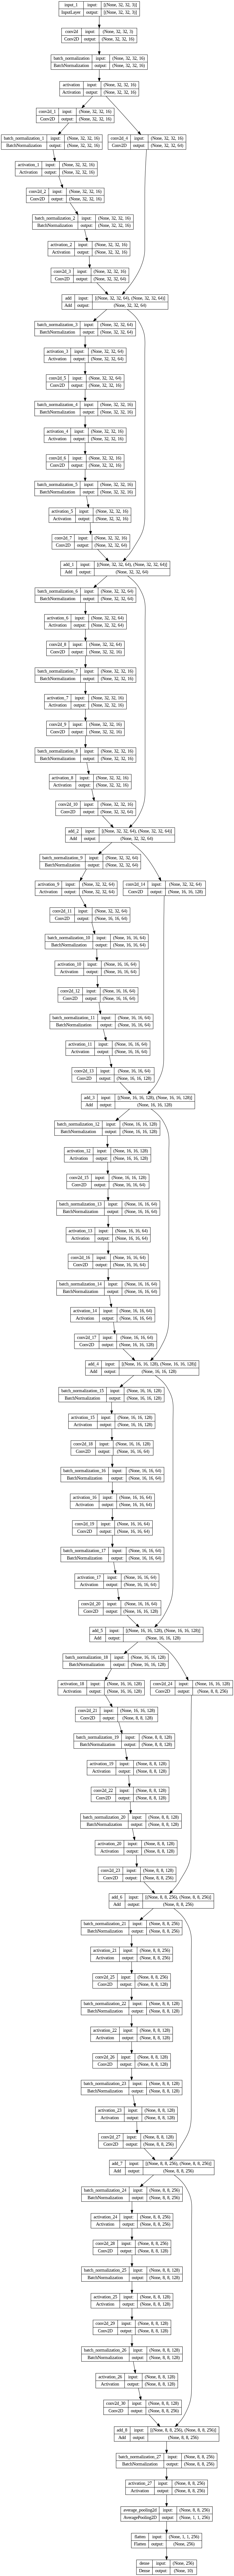

In [9]:
# plot model architecture
plot_model(model, show_shapes=True, to_file= 'alexnet_block.png' )

# Data Augmentation

In [ ]:
# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,
horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(trainX, trainY, batch_size=64)

# Train The Model

In [ ]:
# fit model
steps = int(trainX.shape[0] / 64)
history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=70, validation_data=(testX,
testY), verbose=1)

# Evaluate The Model

In [ ]:
# Plot loss per iteration
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
# evaluate model
_ , acc = model.evaluate(testX, testY, verbose=0)
print( ' > %.3f ' % (acc * 100.0))

# Save The Model

In [ ]:
# Save our model to a file
# Must save as a .h5 format to be able to download it to your pc
model.save('ResNetGC.h5')

In [ ]:
# Check that the model file exists
!ls -1h